In [1]:
import os
import gzip
import csv

import rpy2.ipython
import goatools.obo_parser

In [2]:
project_dir = '/home/dhimmels/Dropbox/lung/followup/interactome/'
go_path = os.path.join(project_dir, 'gene-ontology', 'go-basic.obo')
go_dag = goatools.obo_parser.GODag(obo_file = go_path)

load obo file /home/dhimmels/Dropbox/lung/followup/interactome/gene-ontology/go-basic.obo
44472 nodes imported


In [3]:
def sort_dict_values(dictionary):
    for key, value in dictionary.items():
        dictionary[key] = sorted(value)

In [4]:
# Read Entrez Gene GO annotations
# Download at ftp://ftp.ncbi.nih.gov/gene/DATA/gene2go.gz
gene2go_path = os.path.join(project_dir, 'gene-ontology', 'gene2go.gz')
gene2go_fields = 'tax_id', 'GeneID', 'GO_ID', 'Evidence', 'Qualifier', 'GO_term', 'PubMed', 'Category'
with gzip.open(gene2go_path) as read_file:
    reader = csv.DictReader(read_file, delimiter='\t', fieldnames = gene2go_fields)
    gene2go = [row for row in reader if row['tax_id'] == '9606']

In [5]:
# create a term --> genes (unpropogated) dictionary
annotations = dict()
for annotation in gene2go:
    term = annotation['GO_ID']
    gene_id = int(annotation['GeneID'])
    annotations.setdefault(term, set()).add(gene_id)
sort_dict_values(annotations)
len(annotations)

15202

In [6]:
# create a gene --> terms (unpropogated) dictionary
gene_to_terms = dict()
for term, genes in annotations.iteritems():
    for gene in genes:
        gene_to_terms.setdefault(gene, set()).add(term)
len(gene_to_terms)

18378

In [7]:
# update gene_to_terms with propagated terms
go_dag.update_association(gene_to_terms)

In [8]:
annotations_prop = dict()
for gene, terms in gene_to_terms.iteritems():
    for term in terms:
        annotations_prop.setdefault(term, set()).add(gene)
sort_dict_values(annotations_prop)

In [9]:
def write_annotations(annotations, path):
    """Write annotations (a dict of term --> genes)"""
    write_file = open(path, 'w')
    writer = csv.writer(write_file, delimiter = '\t')
    writer.writerow(['go_id', 'go_term', 'go_domain', 'size', 'genes'])
    for term, genes in sorted(annotations.items()):
        writer.writerow([term, go_dag[term].name, go_dag[term].namespace, len(genes), ';'.join(map(str, genes))])
    write_file.close()

In [10]:
path = os.path.join(project_dir, 'gene-ontology', 'human-annotations-unprop.tsv')
write_annotations(annotations, path)

path = os.path.join(project_dir, 'gene-ontology', 'human-annotations-prop.tsv')
write_annotations(annotations_prop, path)

In [14]:
%load_ext rpy2.ipython

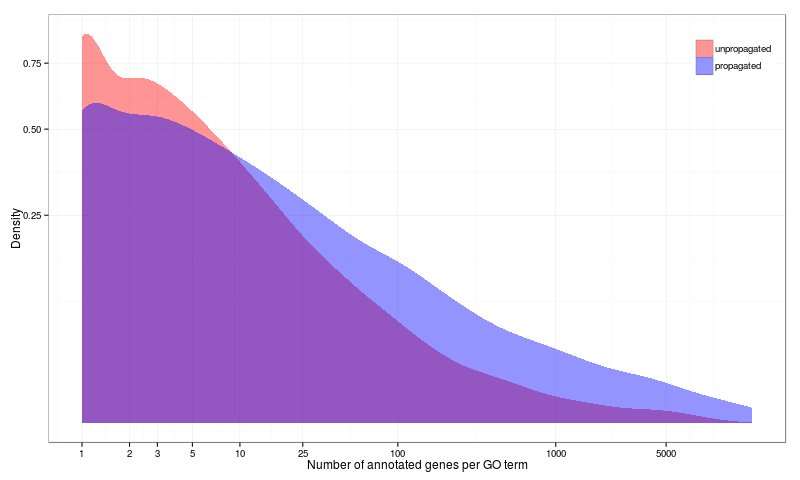

In [16]:
%%R -w 800 -h 480

library(dplyr)
library(ggplot2)

options(stringsAsFactors = FALSE)

project.dir <- '/home/dhimmels/Dropbox/lung/followup/interactome/'

annotation.df <- dplyr::bind_rows(
  file.path(project.dir, 'gene-ontology', 'human-annotations-unprop.tsv') %>%
    read.delim() %>%
    dplyr::mutate(propagation = 'unpropagated'),
  file.path(project.dir, 'gene-ontology', 'human-annotations-prop.tsv') %>%
    read.delim() %>%
    dplyr::mutate(propagation = 'propagated')) %>%
  dplyr::mutate(propagation = factor(propagation, levels=c('unpropagated', 'propagated')))

gg <- annotation.df %>%
  ggplot(aes(x = size, fill = propagation)) +
  geom_density(alpha = 0.42, color = NA, adjust = 2) +
  scale_x_log10(breaks = c(1, 2, 3, 5, 10, 25, 100, 1000, 5000)) +
  scale_y_sqrt() +
  theme_bw() +
  scale_fill_manual(name = '', values = c("#FF0000", "#0000FF")) +
  theme(legend.justification = c(1, 1), legend.position = c(1, 1)) +
  xlab('Number of annotated genes per GO term') + ylab('Density')

file.path(project.dir, 'gene-ontology', 'annotations.svg') %>%
  ggsave(width = 5, height = 4)

print(gg)